In [4]:
#Imports

import matplotlib.pyplot as plt
import itertools
import numpy as np

from EllipticalSliceSampler import EllipticalSampler
from gpc import GPC
from scipy.optimize import minimize
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from typing import Callable, Sequence
from utils import gaussian_kernel, plot_gp_samples, sigmoid

In [2]:
class GPC():
    '''
    A Gaussian Process Classifier class.
    '''
    def __init__(
        self, 
        kernel:Callable, 
        hyperparameters:Sequence, 
        hyperparameter_names: Sequence = [], 
        optimizer:str = "L-BFGS-B"
    ):
        '''
        Args:
            kernel: A kernel function that takes three arguments: X, Y, hyperparameters. 
                hyperparameters should be a list of kernel parameters.
            hyperparameters: A sequence of hyperparmaeters that correspond to the kernel argument.
            hyperparameter_names[optional]: Names of the hyperparameters.
            optimizer[optional]: optimizer by scipy.optimize.minimize to fit the model. 
        '''
        self.kernel= kernel
        self.hyperparameters = hyperparameters
        self.hyperparameters_names = hyperparameter_names

        self.X = None
        self.Y = None
        self.nll = None
        self.optimizer = optimizer

    def _check_is_fitted(self) -> None:
        assert self.X is not None, "There is no data loaded, please fit the model by calling the fit method."

    def _update_hyperparameters(self, hyperparameters) -> None:
        '''Updates hyperparameters of kernel'''
        assert len(hyperparameters) == len(self.hyperparameters), \
            f"Incorrect number of hyperparameters. Expected {len(self.hyperparameters)} instead got {len(hyperparameters)}"
        self.hyperparameters = hyperparameters

    def _get_mu(self, X):
        '''Returns a mean vector of zeros'''
        return np.zeros(len(X))

    def _get_sigma(self, X:np.ndarray, hyperparameters:Sequence = []):
        '''Returns a variance covariance matrix using the specified kernel and hyperparameters. if no hyperparameters are
        specified then uses the class hyperparameters.'''

        if hyperparameters == []:
            hyperparameters = self.hyperparameters

        n = len(X)
        gram_matrix = np.array([np.zeros(n) for _ in range(n)])
        for i, j in itertools.product(range(n), range(n)):
            gram_matrix[i][j] = self.kernel(X[i], X[j], hyperparameters)
        min_eig = np.min(np.real(np.linalg.eigvals(gram_matrix)))
        if min_eig <0:
            gram_matrix -= 10*min_eig * np.eye(*gram_matrix.shape)

        return gram_matrix + 1e-12 * np.identity(n)
    
    def _sigmoid(self, f):
        return 1/(1 + np.exp(-f))

    def _list_to_array(self, x:Sequence):
        if not isinstance(x, np.ndarray):
            x = np.array(x)
        return x

    def _loglikelihood(self, Y, f) -> float:
        '''
        Returns the log likelihood for a binary classification model
        Args:
            Y: Binary labels
            f: Logits (draw from gaussian process)
        '''
        
        f = f.reshape(1, -1)
        Y = self._list_to_array(Y).reshape(1, -1)

        return np.sum([
            np.log(self._sigmoid(f_i)) if y == 1 
            else np.log(self._sigmoid(-f_i)) 
            for f_i, y in zip(f.squeeze().tolist(), Y.squeeze().tolist())
            ])

    def sample_prior(self, X, num_samples:int) -> Sequence:
        '''Draw num_samples from the prior'''
        return np.random.multivariate_normal(self._get_mu(X), self._get_sigma(X), num_samples)
    
    def sample_posterior(self, X, Y, num_burnin:int = 100, num_samples:int = 300, verbose=0, **kwargs) -> Sequence:
        '''Draws num_samples from posterior and discards the first num_burnin samples.'''
        assert num_samples > num_burnin, f"Got {num_samples} but required to burn {num_burnin} samples"

        def log_likelihood(f):
            if len(Y) < len(f): f = f[:len(Y)]
            return self._loglikelihood(Y=Y, f=f)

        ess = EllipticalSampler(self._get_mu(X), self._get_sigma(X,**kwargs), log_likelihood)
        return ess.sample(num_samples, num_burnin, verbose=verbose)

    def posterior_mean(self, X, Y, verbose=0, **kwargs) -> Sequence:
        '''Returns posterior mean'''
        return np.mean(self.sample_posterior(X, Y, verbose=verbose, **kwargs), axis=0)

    def fit(self, X, y, maxiter:int = 100, eps:float = 1e-3, tol:float = 1e-7, verbose=0, **kwargs) -> None:
        '''
        Fits the model and finds the optimal hyperparameters
        
        Args:
            maxiter: max iterations for the optimizer
            eps: step size for the optimizer
            tol: threshold change in the log likelihood for convergence
            verbose: 1 shows the hyperparameters as it updates, 2 also shows progress bar for sampler.
        '''
        self.X = X
        self.Y = y

        def nll(hyperparameters):
            neg_loglikelihood = -1 * self._loglikelihood(Y=self.Y, f=self.posterior_mean(self.X, self.Y, hyperparameters=hyperparameters, **kwargs))
            if verbose >= 1:
                print(f"Neg log likelihood is {neg_loglikelihood}")
            return neg_loglikelihood

        def callback(parameters):
            if verbose >= 1:
                if len(self.hyperparameters_names) == len(parameters):
                    parameter_strings = [str(round(p, 4)) for p in parameters]
                    output = [": ".join(name_param) for name_param in zip(self.hyperparameters_names, parameter_strings)]
                    print(" ".join(output))
                else:
                    print(parameters)

        res = minimize(
            nll, 
            self.hyperparameters, 
            method=self.optimizer, 
            options={"maxiter":maxiter, "ftol": tol, "eps": eps}, 
            callback=callback)
        self._update_hyperparameters(res.x)
        self.nll = res.fun
        print(f"Fitted with final hyperparameters: {self.hyperparameters} and neg log likelihood {res.fun}")
    
    def sample_posterior_predictions(self, X, verbose=0, **kwargs) -> Sequence:
        '''Draws posterior prediction samples by concatenating the new X's with the X's that the model was fitted on.
        returns samples that are n + t x 1 where n is the lenght of the training data and t is the length of the new data
        pass num_samples or num_burnin to the sample posterior method through kwargs
        '''
        self._check_is_fitted()
        X = np.concatenate((self.X, X))
        return self.sample_posterior(X, self.Y, verbose=verbose, **kwargs)


    def predict(self, X, verbose=0, **kwargs) -> float:
        '''Predict function with kwargs being passed to sample_posterior'''
        self._check_is_fitted()
        X = np.concatenate((self.X, X))
        samples = self.sample_posterior(X, self.Y, verbose=verbose, **kwargs)[:, self.X.shape[0]:]
        return np.mean(samples, axis=0), np.var(samples, axis=0)


Above is our Gaussian process classifier class that we implemented to use the implemented slice sampler. It's main functions are sample from the posterior, sampling from the prior fitting, and predicting. To instantiate the class we pass it a kernel function and a list of hyperparameters that definte our gaussian process classifier. The implicit model is a simple binary classification model as we have already described. 

Sampling from the prior is a simple function that draws from the multivariate normal by calling the _get_mu and _get_sigma function which generate a mean vector of zeros and a covariance matrix using the kernel and the X data passed to the function. 

To sample from the posterior we had to first define the log likelihood function, and in particular we define it so that the Y's are fixed and it only accepts a draw f from the posterior distribution. Then we are able to pass this log likelihood function and a prior mean and prior covariance to the elliptical slice sampler which gives us a number of posterior samples. This allows us to draw posterior samples using our pre-defined hyper parameters of the kernel. 

The fit function uses an optimizer (and in this case we use L-BFGS-B) to search for the optimal hyperparameters. In a Bayesian setting we might put priors on the hyper parameters but trying to integrate over such a massive model would be impossible. Instead here, scipy will use optimization routines to numerically approximate the gradient and try to run gradient descent essentially. First we have to redefine our log likelihood function to be a function of the hyperparameters. We do this by defining it as computing the likelihood of the posterior mean (from using the elliptical slice sampler) and certain prior hyperparameters. We change this to negative log likelihood as optimizers typically minimize instead of maximize. 

Here we began to run into many problems trying to optimize this function. From a practical point of view when implementing it is very hard to find out if you have implemented something wrong with your model or it is the data that is making it difficult or simply that the convergence is very slow. For a long time we were unsure and one of our main recommendations, especially when working with a black box optimzier, is to try to make the outputs more verbose. So here we implement a callback function that allows us to watch the hyperparameters change at each iteration. This was in fact not sufficient as we could not observe each function evaluation. This comes from understanding how the optimizer works and understanding that we needed to see each negative log likelihood evaluation to get better diagnostics. A simple print statement in the negative log likelihood method made an incredible difference. After being able to see into this inner loop of the optimizer we realized that it might be the step size that was causing either divergence or very slow convergence. By doing this we could adjust the step size to somethign that works much better and as well that works much faster as this is incredibly important for something that must run the slice sampler many many times. 

When we were adjusting the step size we noticed a problem with the covariance matrix that ended up being not positive semi definite. From theory we know that this is impossible when you use a valid kernel function. So we know this has to due with numerical issues with floating point numbers. At first we used a small number added to the diagonal of the gram matrix, but this did not solve it as theory would suggest and in fact this is a common trick many practitioners use to help with numerical stability but here it was not enough. Finally, we decided to truncate the decimals of the covariance matrix using the minimum value among the eigenvalues. Since this value should be zero, in case we encountered values that diverged from this we knew that floating point errors where occurring. The final solution ended up being a substraction of this minimum value from all the components of the matrix that where not placed in the main diagonal. This in the end solves all our implementation problems.

Finally we have a predict method that concatenates new samples of X and generates a larger covariance matrix which we use to draw posterior samples with using our fitted hyper parameters. Below we create a toy classification example that is easily separable and has two features to understand how this all works. We further generate some out of bounds data that are outside of our normal training sample. 

In [5]:
np.random.seed(0)
X, Y = make_classification(n_samples = 40, n_features=2, n_redundant=0, class_sep=5, random_state=0)
x, x_test, y, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

tol1 = 1e-1
eps1 = 1e-4
tol2 = 1e-1
eps2 = 1
num_samples = 150

def gen_outofbounds_x(x, num_samples, step):
    oob_x = []
    for dim in range(x.shape[1]):
        min_x = np.array([np.min(x[:,dim]) - (i + 1) * step for i in range(num_samples)]) 
        max_x = np.array([np.max(x[:,dim]) + (i + 1) * step for i in range(num_samples)]) 
        x_dim = np.concatenate((min_x, max_x))
        oob_x.append(x_dim)
    return np.vstack(oob_x).T

new_x = gen_outofbounds_x(x, 10, 0.5)

Here we make four sets of samples. We first draw prior samples, then draw posterior samples and then draw two sets of fitted posterior samples using a poor step size and a good step size

In [4]:
gpc = GPC(gaussian_kernel, [1, 1])

prior_samples = gpc.sample_prior(x, num_samples - 100)
posterior_samples = gpc.sample_posterior(x, y, num_samples = num_samples)

gpc1 = GPC(gaussian_kernel, [1,1])
gpc1.fit(x, y, verbose=1, tol=tol1, eps=eps1)
fitted_samples = gpc1.sample_posterior(x, y, num_samples = num_samples)
print(gpc1.hyperparameters)


gpc2 = GPC(gaussian_kernel, [1,1])
gpc2.fit(x, y, verbose=1, tol=tol2, eps=eps2)
fitted_samples2 = gpc2.sample_posterior(x, y, num_samples=num_samples)
print(gpc2.hyperparameters)

/tmp/ipykernel_1005701/565370983.py:46: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if hyperparameters == []:


Neg log likelihood is 8.411236056212388
Neg log likelihood is 9.233812656020232
Neg log likelihood is 7.901715267730157
Neg log likelihood is 17.64802129937651
Neg log likelihood is 16.493611634390522
Neg log likelihood is 16.332138267543836
Neg log likelihood is 12.546312198410927
Neg log likelihood is 11.465714434604866
Neg log likelihood is 9.61222398091515
Neg log likelihood is 8.908092689254358
Neg log likelihood is 8.725033854865796
Neg log likelihood is 7.212490210830425
Neg log likelihood is 10.050511342330383
Neg log likelihood is 9.041702124562045
Neg log likelihood is 9.186312434604233
Neg log likelihood is 10.297070864392811
Neg log likelihood is 9.720942890718359
Neg log likelihood is 9.971832069635132
Neg log likelihood is 7.641892595061022
Neg log likelihood is 7.550282752423796
Neg log likelihood is 8.916396820950212
[0.99720336 1.0017323 ]
Fitted with final hyperparameters: [0.99720336 1.0017323 ] and neg log likelihood 7.641892595061022
[0.99720336 1.0017323 ]
Neg log

We can watch the verbose output as we fit and notice how the step size when it is set poorly does not manage to move the log likelihood as it is not able to explore far enough relative to the gradients of the log likelihood. Below we generate some posterior samples and save some variables for plotting

In [5]:
models = [gpc, gpc, gpc1, gpc2]

titles = [
    "Prior Samples",
    "Posterior Samples",
    f"Fitted Samples tol={tol1} eps={eps1}",
    f"Fitted samples tol={tol2} eps = {eps2}"
]

samples = [
    prior_samples, 
    posterior_samples,
    fitted_samples,
    fitted_samples2
]

predictions_samples = [
    gpc.sample_prior(np.vstack([x, x_test]), num_samples=num_samples- 100),
    gpc.sample_posterior(np.vstack([x, x_test]), y, num_samples=num_samples),
    gpc1.sample_posterior_predictions(x_test, num_samples=num_samples),
    gpc2.sample_posterior_predictions(x_test, num_samples=num_samples)
]

hyperparameters = [
    [round(p, 3) for p in model.hyperparameters] 
    for model in models
]

nlls = [
    round(np.mean([- model._loglikelihood(y, s) for s in sample]), 3)
    for model, sample in zip(models, samples)
]


Here we plot the fits for our model. We can see everything we would expect. The prior samples simple show a gaussian kernel that sits at the mean, especially when there is no information. It only encodes the covariance matrix and does not take advantage of the likelihood of the data. The posterior sample fits to the data more so than the prior as we would expect. Notice that the fitted sample using a step size of 1e-4 does not work and the negative log likelihood is more or less unchanged, but if we use a proper step size of 1 then we are able to fit better hyper parameters for the kernel. If we look at the first figure which plots along the first dimension of the design matrix we might wonder why bother with optimizing. We could have just looked at the data and intuited that we would have want a high length scale to smooth the gaussian kernel and a relatively low variance and we would have gotten a good fit. Notice actually that the hyperparameters (shown as variance then length scale) use a rather high variance as well which is counter intuitive. The reason is evident when we look at the second dimension. The data is not as obviously separable and we see why we needed a high variance to fit. Finally, we can see that the model has a lot of uncertainty where there is not data. This is of course a toy example, but shows how we would have no hope of simply visually guessing the good hyper parameters if the dimension of x were larger or the kernels were more complicated. This motivates the use of the blackbox optimizer. 

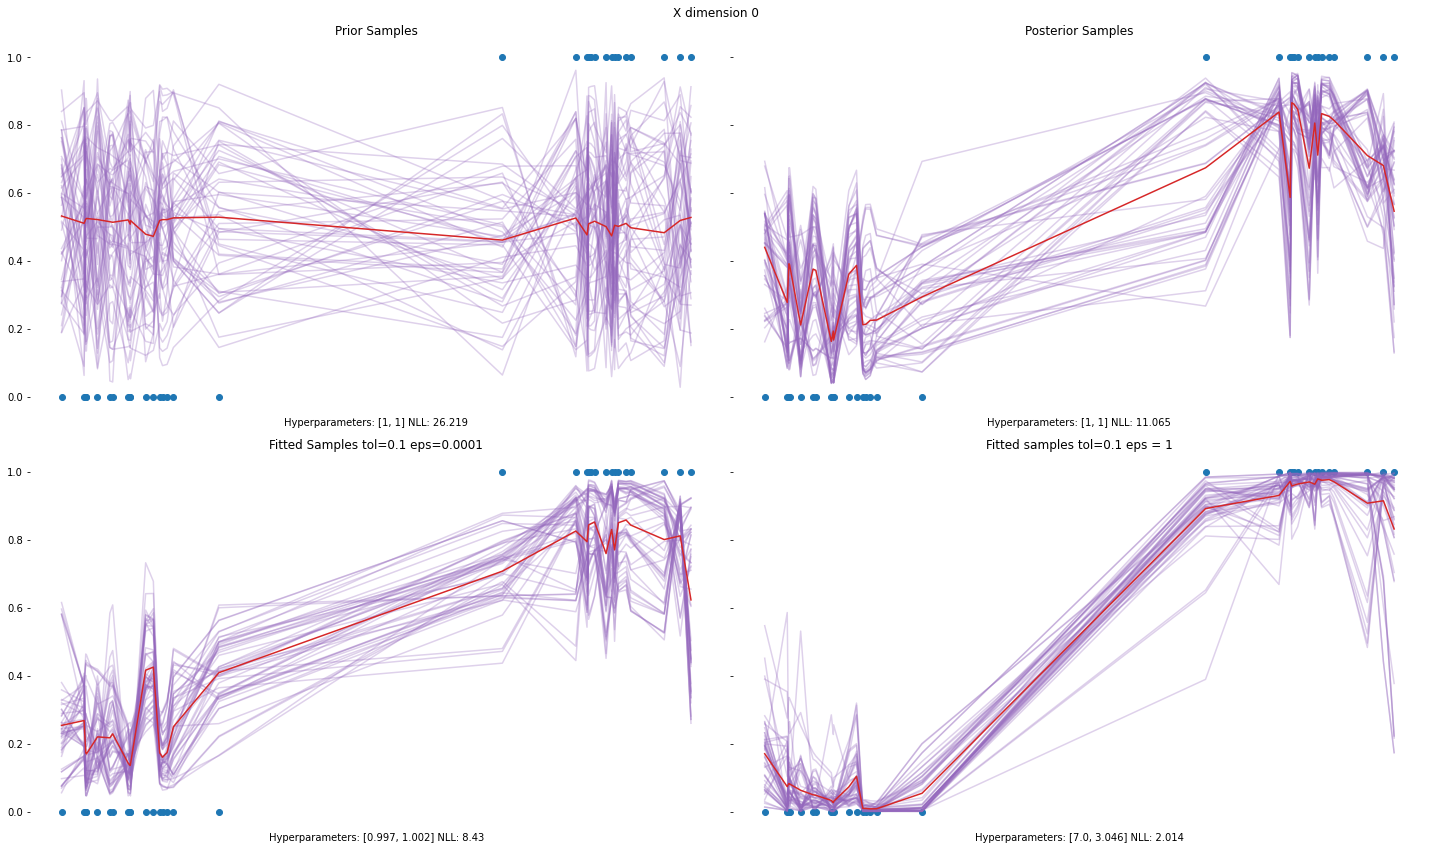

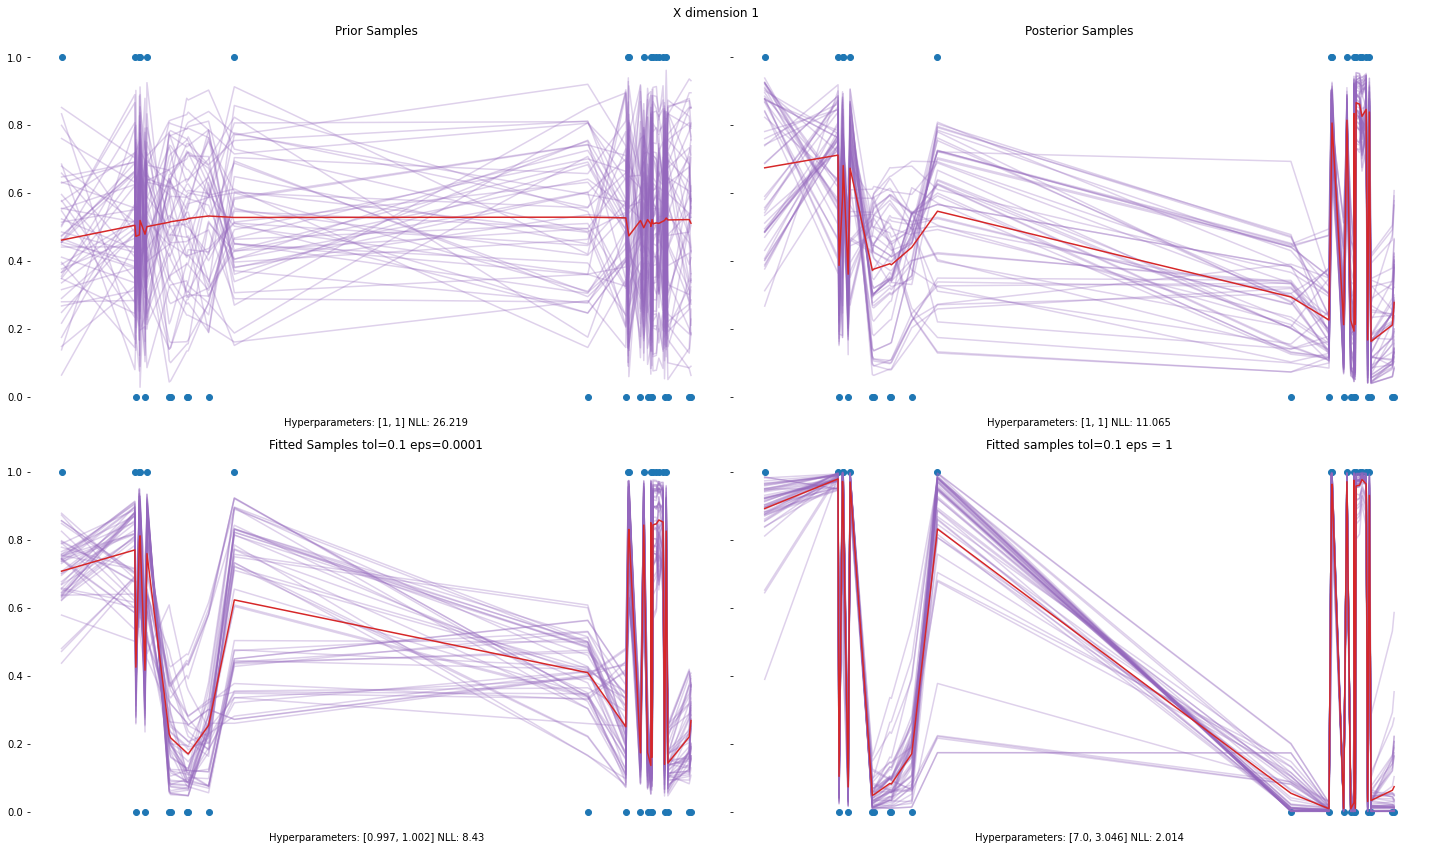

In [10]:
def plot_example(x_dim, x, y, titles, samples, x_test = None, y_test = None):
    fig, axs = plt.subplots(2, 2, figsize=(20, 12), sharey=True, tight_layout=True)
    for i, ax in enumerate(axs.ravel()):
        if x_test is not None:
            if y_test is not None:
                ax.scatter(x_test[:, x_dim], y_test, color="black")
            x_stack = np.vstack([x, x_test])
            plot_gp_samples(x_stack, samples[i], ax=ax, x_dim=x_dim)
        else:
            plot_gp_samples(x, samples[i], ax=ax, x_dim=x_dim)
        ax.set_title(titles[i])
        ax.set_xlabel(f"Hyperparameters: {hyperparameters[i]} NLL: {nlls[i]}")
        for spine in ["top", "bottom", "right", "left"]:
            ax.spines[spine].set_visible(False)
        ax.set_xticks([])
        ax.scatter(x[:,x_dim], y, color="tab:blue")
    fig.suptitle(f"X dimension {x_dim}")
    return fig

fig = plot_example(0, x, y, titles, samples)

fig2 = plot_example(1, x, y, titles, samples)

Here we plot some held out sample predictions. Because of the nature of classification it is hard to see the use of the gaussian process and its uncertainty quantifications. The test points are in black and although the above plots might have had you thinking that there is some overfitting, actually we can see below that our predictions are fairly accurate for this test data. We can see that the fitted sample also predicts more accurately than the unfitted simple posterior draws. 

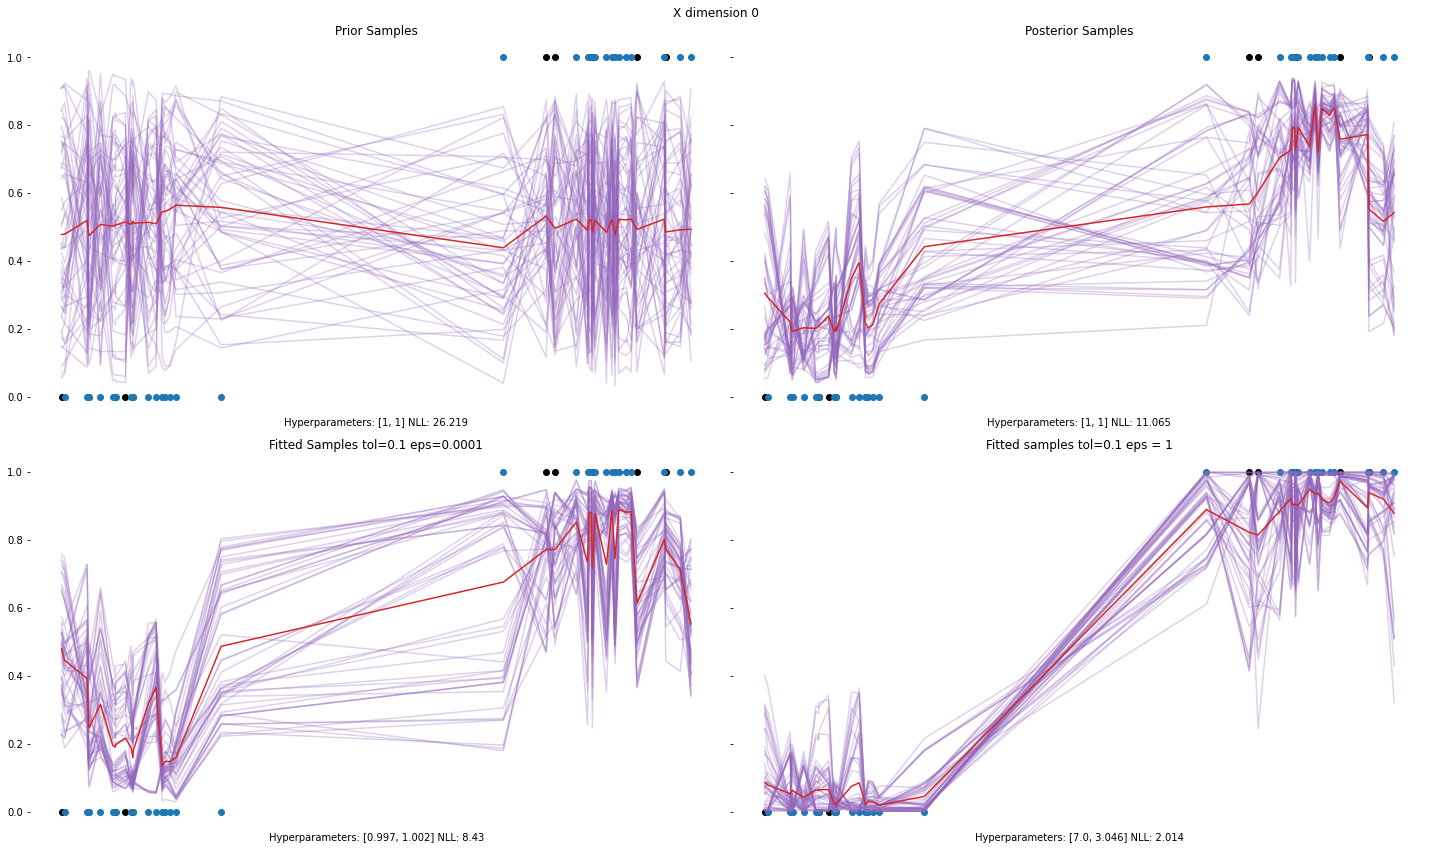

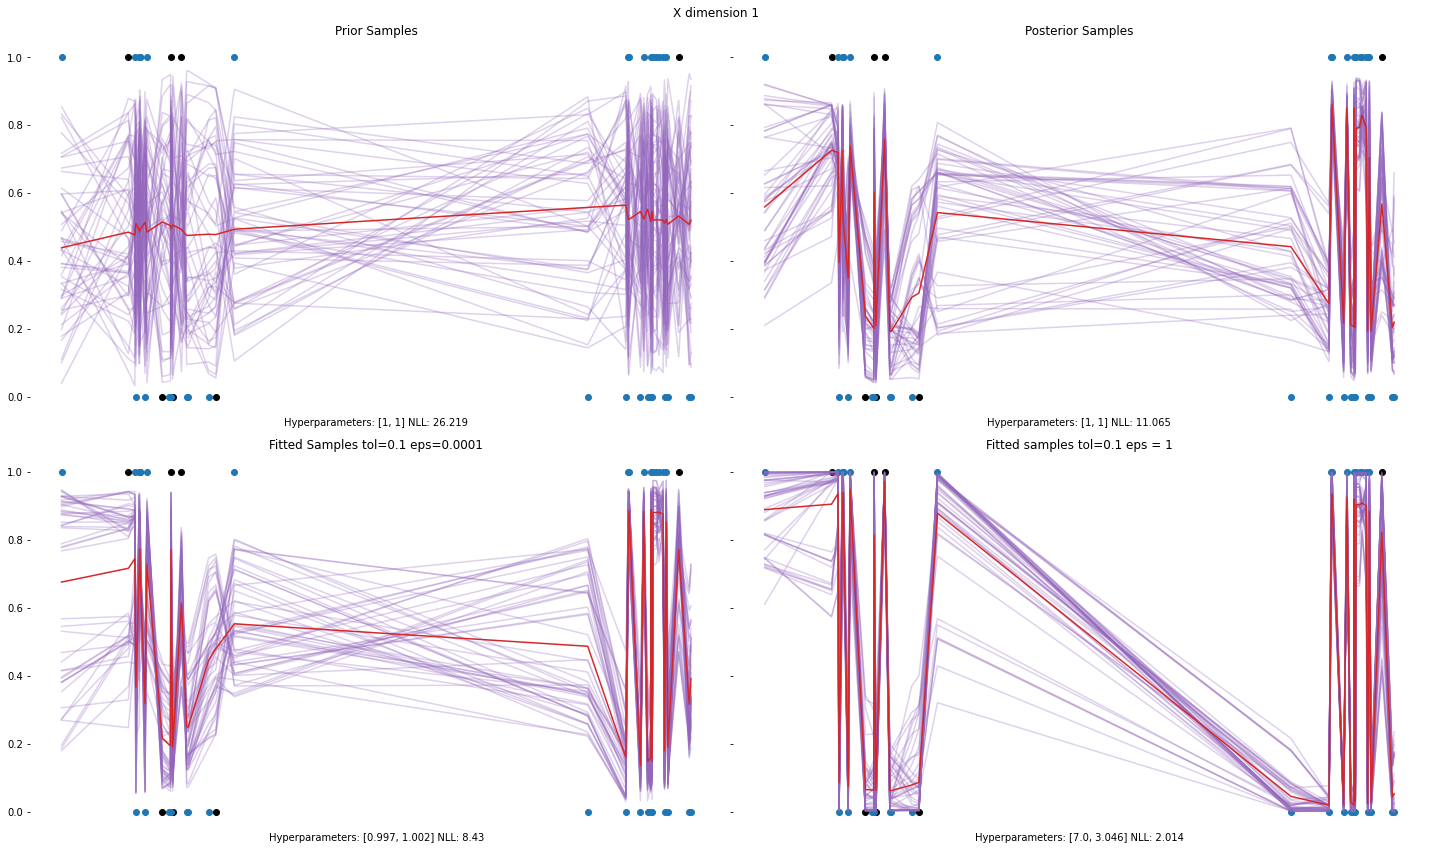

In [11]:

pred_fig = plot_example(
    0, 
    x, 
    y,
    titles, 
    predictions_samples,
    x_test,
    y_test
)

pred_fig2 = plot_example(
    1, 
    x,
    y,
    titles, 
    predictions_samples,
    x_test,
    y_test
)

Here we can quickly look at the accuracy and mse for the eight test points and see that although every one classifies correctly, but we have lower MSE when the model is properly fitted. 

In [38]:
def pred_labels(pred_samples, n_train):
    point_preds = sigmoid(np.mean(pred_samples, axis=0)[n_train:])
    pred_labels = [1 if pred >= 0.5 else 0 for pred in point_preds]
    return pred_labels, point_preds

y_preds= [pred_labels(pred_sample, len(x)) for pred_sample in predictions_samples]
y_labels, y_probas = zip(*y_preds)

for title, y_pred, y_proba in zip(titles, y_labels, y_probas):
    accuracy = 1 -  np.sum(np.abs((np.array(y_pred) - y_test)))/len(y_test)
    mse = np.mean((np.array(y_proba) - y_test)**2)
    print(f"{title} had accuracy {accuracy} and mse {mse}")

Prior Samples had accuracy 0.25 and mse 0.248297645672761
Posterior Samples had accuracy 1.0 and mse 0.09825743488628935
Fitted Samples tol=0.1 eps=0.0001 had accuracy 1.0 and mse 0.07771462136672394
Fitted samples tol=0.1 eps = 1 had accuracy 1.0 and mse 0.0015295879547373094


Finally we draw some sample predictions on our out of sample data. 

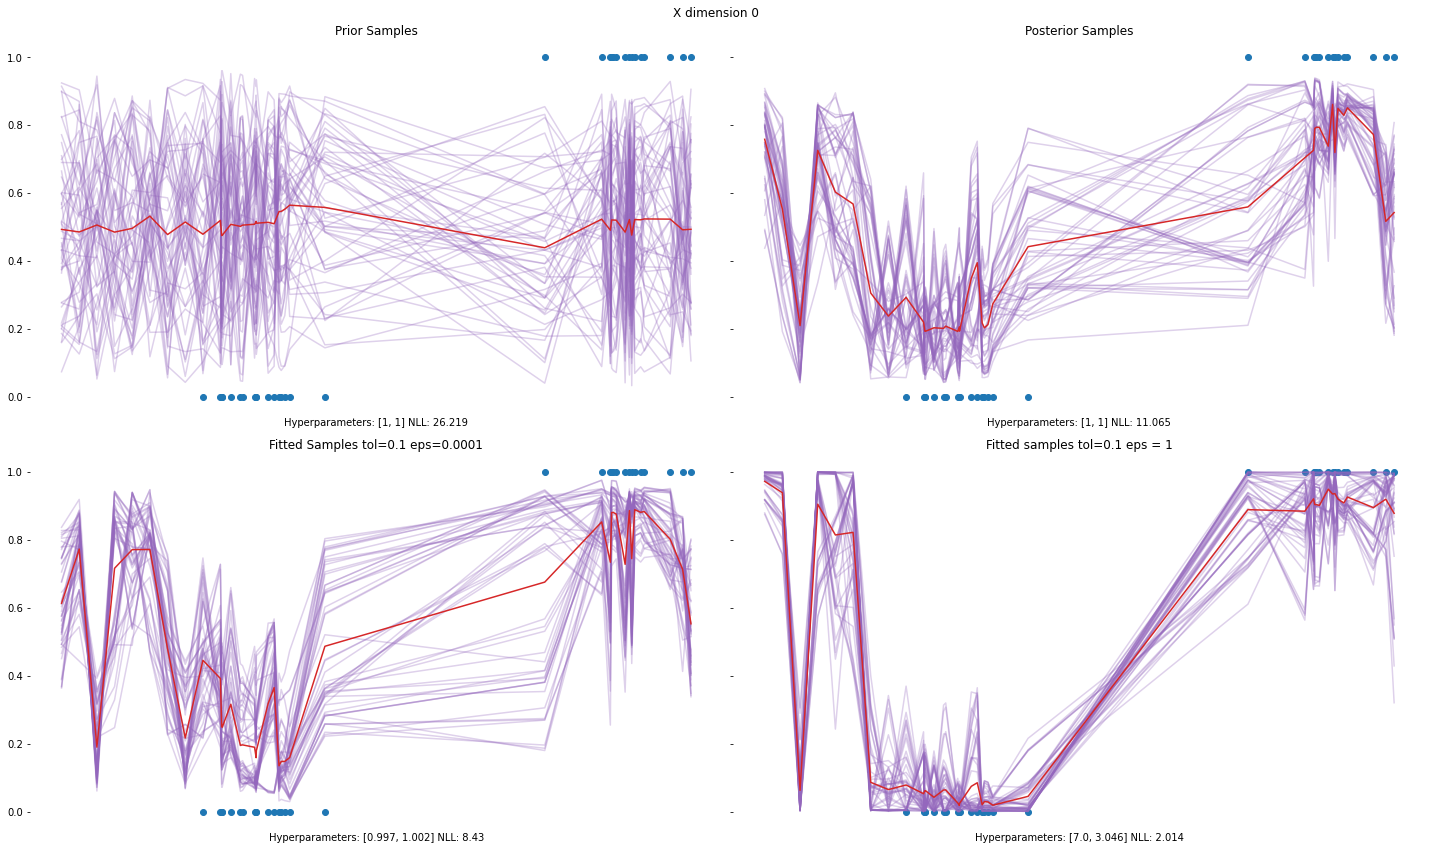

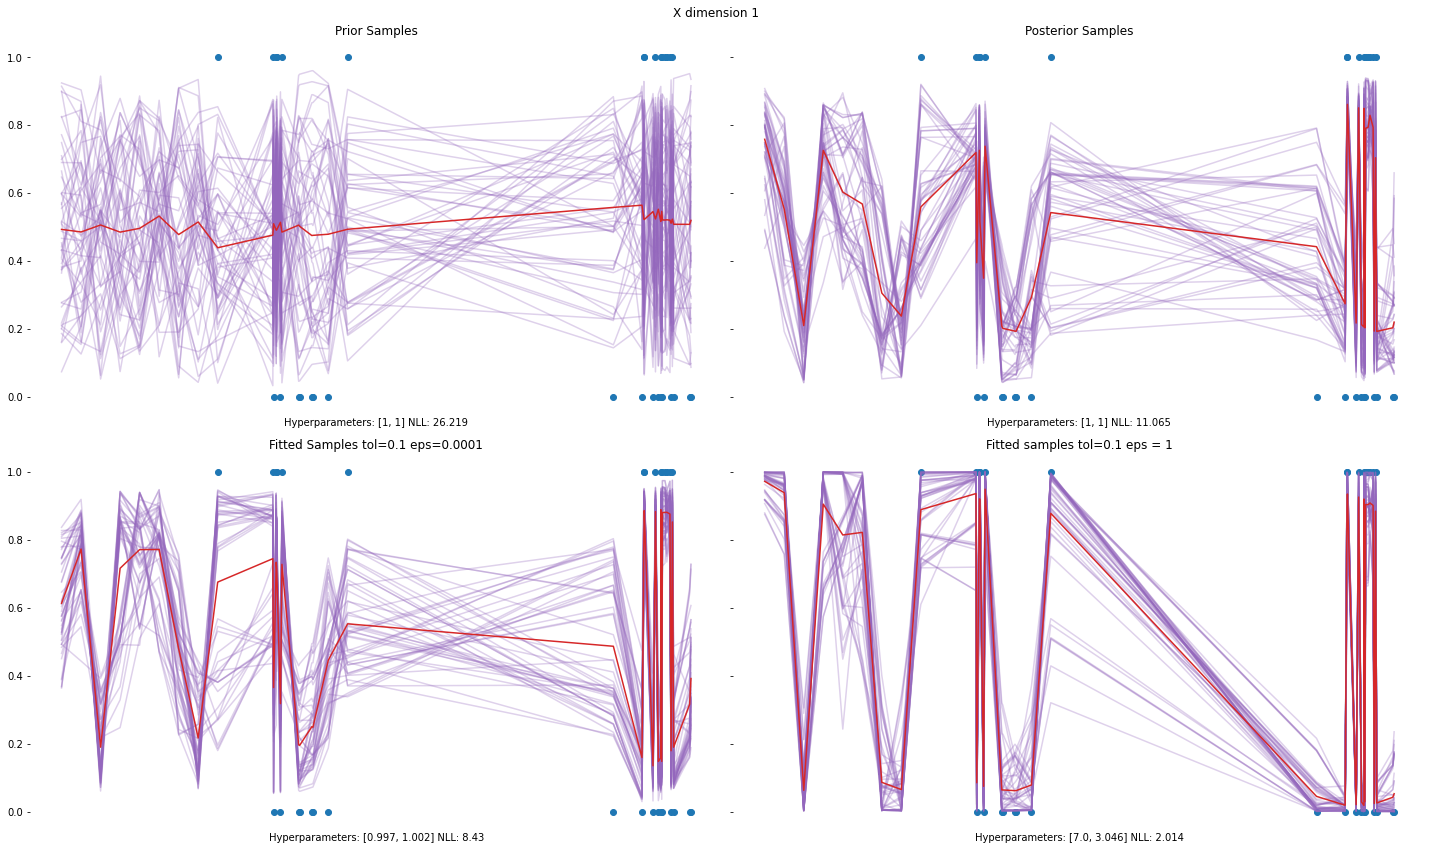

In [12]:
pred_fig_oob1 = plot_example(
    0, 
    x, 
    y,
    titles, 
    predictions_samples,
    new_x
)

pred_fig_oob2 = plot_example(
    1, 
    x,
    y,
    titles, 
    predictions_samples,
    new_x
)


In [13]:
import pandas as pd
Y = pd.read_pickle("/Users/danil/BSE/Term2/ProbInf/GP-Classification-Project/data/clean/clean_y_train.pkl")
posterior_samples = pd.read_pickle("/Users/danil/BSE/Term2/ProbInf/GP-Classification-Project/data/clean/posterior_samples.pkl")

posterior_mean = np.mean(posterior_samples, axis= 0)

In [19]:
def loglikelihood(Y, f) -> float:
        '''
        Returns the log likelihood for a binary classification model
        Args:
            Y: Binary labels
            f: Logits (draw from gaussian process)
        '''
        
        f = np.array(f).reshape(1, -1)
        Y = np.array(Y).reshape(1, -1)

        return np.sum([
            np.log(sigmoid(f_i)) if y == 1 
            else np.log(sigmoid(-f_i)) 
            for f_i, y in zip(f.squeeze().tolist(), Y.squeeze().tolist())
            ])

def AIC(f, Y):
    return 4 - loglikelihood(Y,f)

def BIC(f,Y):
    return 2*np.log(len(Y)) - loglikelihood(Y,f)

def WAIC(Y,posterior_samples):
   return -2*np.mean([loglikelihood(Y, f) for f in posterior_samples]) + 2*loglikelihood(Y, np.mean(posterior_samples, axis= 0))    


In [21]:
print(AIC(posterior_mean, Y))
print(BIC(posterior_mean, Y))
print(WAIC(Y, posterior_samples))

182.91475922721798
190.45140121880553
46.12251352555177
